## Summary

---

## Imports

In [1]:
import functools
import json
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from sklearn import metrics, model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4yhy2_w8 because the default path (/home/p/pmkim/strokach/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("40_cagi6_sherloc_submission").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/40_cagi6_sherloc_submission')

## Load data

In [4]:
submission_template_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "submission_template.tsv"
)

submission_template_df = pd.read_csv(submission_template_file, sep="\t")

display(submission_template_df.head(2))
len(submission_template_df)

,hgvs,score,class,comment
0,NM_152486.2:c.39C>T,*,*,*
1,NM_152486.2:c.62C>T,*,*,*


122124

### `training_df`

In [5]:
training_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc",
    "CAGI6-Sherloc-clinical-classification",
    "final_train_070821.txt",
)

In [6]:
training_all_df = pd.read_csv(training_file, sep="\t")

display(training_all_df.head(2))
len(training_all_df)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,pos,ref,alt,hgvs,interpretation,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861332,G,A,NM_152486.2:c.11G>A,Uncertain significance,True,False,False
1,1,865568,G,A,NM_152486.2:c.106G>A,Uncertain significance,True,False,False


418354

In [7]:
assert not set(submission_template_df["hgvs"]) & set(training_all_df["hgvs"])

In [8]:
training_df = training_all_df[training_all_df["Subcategory Missense"]]

display(training_df.head(2))
len(training_df)

,chr,pos,ref,alt,hgvs,interpretation,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861332,G,A,NM_152486.2:c.11G>A,Uncertain significance,True,False,False
1,1,865568,G,A,NM_152486.2:c.106G>A,Uncertain significance,True,False,False


217153

### `testing_df`

In [9]:
testing_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "CAGI6-Sherloc-clinical-classification", "final_test_070821.txt"
)

In [10]:
testing_all_df = pd.read_csv(testing_file, sep="\t")

display(testing_all_df.head(2))
len(testing_all_df)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,pos,ref,alt,hgvs,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861360,C,T,NM_152486.2:c.39C>T,False,False,False
1,1,861383,C,T,NM_152486.2:c.62C>T,True,False,False


122124

In [11]:
assert not set(submission_template_df["hgvs"]) ^ set(testing_all_df["hgvs"])

In [12]:
testing_df = testing_all_df[testing_all_df["Subcategory Missense"]]

display(testing_df.head(2))
len(testing_df)

,chr,pos,ref,alt,hgvs,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
1,1,861383,C,T,NM_152486.2:c.62C>T,True,False,False
7,1,865640,G,A,NM_152486.2:c.178G>A,True,False,False


47103

### `submission_template_df`

In [13]:
submission_template_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "submission_template.tsv"
)

In [14]:
submission_template_df = pd.read_csv(submission_template_file, sep="\t")

display(submission_template_df.head(2))
len(submission_template_df)

,hgvs,score,class,comment
0,NM_152486.2:c.39C>T,*,*,*
1,NM_152486.2:c.62C>T,*,*,*


122124

### `validation_df`

In [15]:
validation_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "validation_variants.tsv"
)

In [16]:
validation_all_df = pd.read_csv(validation_file, sep="\t").rename(
    columns={"HGVS.c": "hgvs_g"}
)

display(validation_all_df.tail(2))
len(validation_all_df)

,hgvs_g
17812,NC_000023.10:g.32519861C>T
17813,NC_000015.9:g.85406864_85406865insT


17814

In [17]:
def map_g_to_c(str_g, mapper):
    from hgvs.exceptions import HGVSInvalidIntervalError, HGVSUsageError

    var_g = hp.parse_hgvs_variant(str_g)
    for tx_ac in mapper.relevant_transcripts(var_g):
        try:
            var_c = mapper.g_to_c(var_g, tx_ac)
        except (HGVSUsageError, HGVSInvalidIntervalError):
            continue
        yield var_c

In [18]:
validation_mapping_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "validation-mapping-grch37.parquet"
)

if validation_mapping_file.is_file():
    validation_mapping_df = pq.read_table(validation_mapping_file).to_pandas()
else:
    import hgvs.assemblymapper
    import hgvs.dataproviders.uta
    import hgvs.parser

    hp = hgvs.parser.Parser()
    hdp = hgvs.dataproviders.uta.connect()
    mapper = hgvs.assemblymapper.AssemblyMapper(
        hdp, assembly_name="GRCh37", normalize=False
    )

    results = []
    for tup in tqdm(validation_all_df.itertuples(), total=len(validation_all_df)):
        for var_c in map_g_to_c(tup.hgvs_g, mapper):
            results.append((tup.str_g, str(var_c)))
    validation_mapping_df = pd.DataFrame(results, columns=["hgvs_g", "hgvs"])
    pq.write_table(
        pa.Table.from_pandas(validation_mapping_df, preserve_index=False),
        validation_mapping_file,
    )

In [19]:
display(validation_mapping_df.head(2))
print(len(validation_mapping_df))

,hgvs_g,hgvs
0,NC_000002.11:g.152537358A>G,NM_001164508.1:c.2944-16T>C
1,NC_000002.11:g.152537358A>G,NM_004543.4:c.2944-16T>C


67819


In [20]:
validation_df = (
    validation_all_df
    #
    .merge(validation_mapping_df, on=["hgvs_g"], how="left")
)

In [21]:
display(validation_df.tail(2))
print(len(validation_df))
print(len(validation_df["hgvs_g"].unique()))

,hgvs_g,hgvs
67830,NC_000023.10:g.32519861C>T,NM_004010.3:c.2011+11G>A
67831,NC_000015.9:g.85406864_85406865insT,NM_020778.4:c.5098_5099insT


67832
17814


## Load results

In [22]:
input_file = NOTEBOOK_DIR.parent.joinpath(
    "37_cagi6_sherloc_combine_results", "combined-results.parquet"
)

input_file

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/37_cagi6_sherloc_combine_results/combined-results.parquet')

In [23]:
result_df = pq.read_table(input_file).to_pandas()

display(result_df.head(2))
print(len(result_df))

,protein_id,mutation,mutation_id,effect,proteinsolver_core_score_wt,proteinsolver_core_features_residue_wt,proteinsolver_core_features_protein_wt,protbert_core_score_wt,protbert_core_features_residue_wt,protbert_core_features_protein_wt,msa_count_wt,msa_count_total,msa_proba_wt,msa_proba_total,msa_length,msa_proba,msa_H,msa_KL,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,rosetta_dslf_fa13_wt,rosetta_hbond_sc_wt,rosetta_hbond_bb_sc_wt,rosetta_hbond_lr_bb_wt,rosetta_hbond_sr_bb_wt,rosetta_fa_intra_elec_wt,rosetta_fa_elec_wt,rosetta_lk_ball_bridge_uncpl_wt,rosetta_lk_ball_bridge_wt,rosetta_lk_ball_iso_wt,rosetta_lk_ball_wt,rosetta_fa_intra_sol_xover4_wt,rosetta_fa_intra_rep_xover4_wt,rosetta_fa_intra_atr_xover4_wt,rosetta_fa_sol_wt,rosetta_fa_rep_wt,rosetta_fa_atr_wt,rosetta_dg_wt,rosetta_cart_bonded_change,rosetta_rama_prepro_change,rosetta_ref_change,rosetta_hxl_tors_change,rosetta_p_aa_pp_change,rosetta_fa_dun_semi_change,rosetta_fa_dun_rot_change,rosetta_fa_dun_dev_change,rosetta_omega_change,rosetta_dslf_fa13_change,rosetta_hbond_sc_change,rosetta_hbond_bb_sc_change,rosetta_hbond_lr_bb_change,rosetta_hbond_sr_bb_change,rosetta_fa_intra_elec_change,rosetta_fa_elec_change,rosetta_lk_ball_bridge_uncpl_change,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,alphafold_core_scores_residue_plddt_wt,alphafold_core_scores_protein_plddt_wt,alphafold_core_scores_protein_max_predicted_aligned_error_wt,alphafold_core_scores_proten_ptm_wt,alphafold_core_features_residue_experimentally_resolved_wt,alphafold_core_features_residue_predicted_lddt_wt,alphafold_core_features_residue_msa_first_row_wt,alphafold_core_features_residue_single_wt,alphafold_core_features_residue_structure_module_wt,alphafold_core_features_protein_experimentally_resolved_wt,alphafold_core_features_protein_predicted_lddt_wt,alphafold_core_features_protein_msa_first_row_wt,alphafold_core_features_protein_single_wt,alphafold_core_features_protein_structure_module_wt,el2_score,proteinsolver_core_score_change,proteinsolver_core_features_residue_change,proteinsolver_core_features_protein_change,protbert_core_score_change,protbert_core_features_residue_change,protbert_core_features_protein_change,msa_count_change,msa_proba_change,alphafold_core_scores_residue_plddt_change,alphafold_core_scores_protein_plddt_change,alphafold_core_scores_protein_max_predicted_aligned_error_change,alphafold_core_scores_proten_ptm_change,alphafold_core_features_residue_experimentally_resolved_change,alphafold_core_features_residue_predicted_lddt_change,alphafold_core_features_residue_msa_first_row_change,alphafold_core_features_residue_single_change,alphafold_core_features_residue_structure_module_change,alphafold_core_features_protein_experimentally_resolved_change,alphafold_core_features_protein_predicted_lddt_change,alphafold_core_features_protein_msa_first_row_change,alphafold_core_features_protein_single_change,alphafold_core_features_protein_structure_module_change,aa_wt_onehot,aa_mut_onehot
0,P26678,R9C,NM_002667.3:c.25C>T,Pathogenic,0.091593,"[0.48249053955078125, 0.24484702944755554, -0....","[-2.27313494682312, 0.6932704448699951, -0.195...",0.068529,"[0.15305250883102417, -0.11011786758899689, 0....","[0.05504663661122322, -0.04564127326011658, 0....",87.0,100.0,-0.310155,-88.633441,101.0,-0.536553,0.326639,2.625994,34.796667,18.080333,13.08,5.875333,-4.878333,33.826333,30.420,37.201667,16.900333,0.0,0.0,-0.495,0.0,-46.239,-5.748,-96.294333,-1.515667,-0.220333,-145.437333,123.757667,12.501667,9.146667,-22.659333,279.312667,18.309,-311.028667,-1.308,-0.577667,0.614667,4.553,0.021333,0.376000,0.173000,-1.592000,-0.074667,-0.012667,0.0,

221816


In [24]:
effect_map = {
    "Uncertain significance": 0,
    "Likely benign": -1,
    "Benign": -2,
    "Likely pathogenic": 1,
    "Pathogenic": 2,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

## Exploratory data analysis

In [25]:
proteinsolver_columnms = [c for c in result_df if c.startswith("proteinsolver_")]
protbert_columns = [c for c in result_df if c.startswith("protbert_")]
rosetta_columns = [c for c in result_df if c.startswith("rosetta_")]
alphafold_columns = [c for c in result_df if c.startswith("alphafold_")]

In [26]:
result_df["effect"].value_counts()

Uncertain significance    147067
Likely benign              11398
Benign                      9730
Pathogenic                  5834
Likely pathogenic           2506
Name: effect, dtype: int64

In [27]:
effect_map = {
    "Uncertain significance": 0,
    "Likely benign": -1,
    "Benign": -2,
    "Likely pathogenic": 1,
    "Pathogenic": 2,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

In [28]:
score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    "rosetta_dg_change",
    #     "alphafold_core_scores_residue_plddt_wt",
    #     "alphafold_core_scores_protein_plddt_wt",
    #     "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
    #     "alphafold_core_scores_proten_ptm_wt",
]

df = result_df.dropna(subset=score_columns + ["effect_score"])
# df = df[df["effect_score"].isin([-1, 1])].reset_index(drop=True)

for col in score_columns:
    corr = stats.spearmanr(df["effect_score"], df[col])
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    print(col, corr[0], auc)

el2_score 0.19271749853401182 0.819760687160709
proteinsolver_core_score_change 0.11067870025313856 0.6783941301907526
protbert_core_score_change 0.1620701018909018 0.7812989848001559
rosetta_dg_change 0.10357751324165007 0.6450253131239799


## Load ML models

In [29]:
UNIQUE_ID = "6999e5aa"

UNIQUE_ID

'6999e5aa'

In [30]:
# MODEL_TYPE = "initial"
MODEL_TYPE = "optimized"

MODEL_TYPE

'optimized'

### Features

In [31]:
with NOTEBOOK_DIR.parent.joinpath(
    "38_cagi6_sherloc_train_model", UNIQUE_ID, "scalar-features.json"
).open("rb") as fin:
    scalar_features = json.load(fin)

with NOTEBOOK_DIR.parent.joinpath(
    "38_cagi6_sherloc_train_model", UNIQUE_ID, "vector-features.json"
).open("rb") as fin:
    vector_features = json.load(fin)

len(scalar_features), len(vector_features)

(71, 11)

### Features to exclude

In [32]:
if MODEL_TYPE == "initial":
    features_to_exclude = None
elif MODEL_TYPE == "optimized":
    with NOTEBOOK_DIR.parent.joinpath(
        "39_cagi6_sherloc_finetune_model", UNIQUE_ID, "best-features-to-exclude.json"
    ).open("rt") as fin:
        features_to_exclude = json.load(fin)

features_to_exclude[:3]

[71, 72, 73]

### Parameters

In [33]:
if MODEL_TYPE == "initial":
    with NOTEBOOK_DIR.parent.joinpath(
        "38_cagi6_sherloc_train_model", UNIQUE_ID, "best-parameters-starting.json"
    ).open("rb") as fin:
        best_parameters = json.load(fin)
elif MODEL_TYPE == "optimized":
    with NOTEBOOK_DIR.parent.joinpath(
        "39_cagi6_sherloc_finetune_model", UNIQUE_ID, "best-parameters.json"
    ).open("rt") as fin:
        best_parameters = json.load(fin)

best_parameters

{'objective': 'binary',
 'metric': 'average_precision',
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 142,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7890900321866278,
 'bagging_freq': 7,
 'min_child_samples': 100}

### Models

In [34]:
if MODEL_TYPE == "initial":
    model_filename_template = str(
        NOTEBOOK_DIR.parent.joinpath(
            "38_cagi6_sherloc_train_model", UNIQUE_ID, "model_starting_{model_idx}.json"
        )
    )
elif MODEL_TYPE == "optimized":
    model_filename_template = str(
        NOTEBOOK_DIR.parent.joinpath(
            "39_cagi6_sherloc_finetune_model",
            UNIQUE_ID,
            "best-model-{model_idx}.txt",
        )
    )

models = []
for model_idx in range(6):
    model = lgb.Booster(model_file=model_filename_template.format(model_idx=model_idx))
    models.append(model)

len(models)

6

## Make predictions

In [35]:
try:
    prediction_df
except NameError:
    prediction_df = result_df.dropna(subset=scalar_features + vector_features).copy()

X_ref = np.c_[
    prediction_df[scalar_features].values,
    np.hstack([np.vstack(prediction_df[col].values) for col in vector_features]),
]

if features_to_exclude is not None:
    feature_mask = np.ones(X_ref.shape[1], dtype=bool)
    feature_mask[np.array(features_to_exclude, dtype=int)] = False
    X = X_ref[:, feature_mask]
    assert len(features_to_exclude) == X_ref.shape[1] - X.shape[1]
else:
    X = X_ref

for model_idx, model in enumerate(models):
    prediction_df[f"pred_{model_idx}"] = model.predict(X)

pred_column = f"pred_{UNIQUE_ID}_{MODEL_TYPE}"
prediction_df[pred_column] = prediction_df[
    [f"pred_{model_idx}" for model_idx in range(len(models))]
].mean(axis=1)

pred_column

'pred_6999e5aa_optimized'

## Evaluate predictions

### See validation score

### Submit predictions to leaderboard

In [36]:
pred_column = "pred_6999e5aa_optimized"

validation_submission_df = validation_df.assign(
    is_missense=lambda df: df["hgvs"].notnull()
).merge(
    prediction_df.rename(columns={pred_column: "pred"}),
    left_on=["hgvs"],
    right_on=["mutation_id"],
    how="left",
)

assert len(validation_submission_df) == len(validation_df)

median = np.nanmedian(validation_submission_df["pred"])
print(f"{median=}")

out = (
    validation_submission_df.groupby("hgvs_g")
    .agg({"pred": np.nanmean, "is_missense": "max"})
    .fillna(median)
    .reset_index()
)

median_adj = median / out["pred"].max()
out["pred"] = out["pred"] / out["pred"].max()

out.head()

median=0.09933652166776265


,hgvs_g,pred,is_missense
0,NC_000001.10:g.10032239T>C,0.099891,True
1,NC_000001.10:g.100327066_100327067delinsAT,0.099891,True
2,NC_000001.10:g.100329994A>G,0.099891,True
3,NC_000001.10:g.100340374A>G,0.099891,True
4,NC_000001.10:g.100340991A>G,0.099891,True


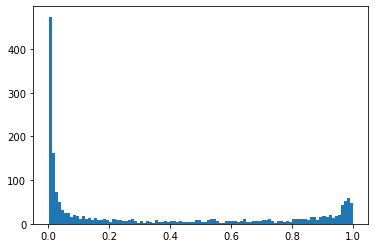

In [37]:
plt.hist(out[out["pred"] != median_adj]["pred"], bins=100)
None

In [38]:
out[["hgvs_g", "pred"]].to_csv(
    NOTEBOOK_DIR.joinpath("submission-valid-7.tsv"), index=False, sep="\t"
)

### Final submission

In [39]:
submission_score_columns = [
    "pred_6999e5aa_optimized",
    "el2_score",
    "protbert_core_score_change",
    "proteinsolver_core_score_change",
    "rosetta_dg_change",
]

In [40]:
assert len(prediction_df) == len(prediction_df["mutation_id"].unique())

In [41]:
final_submission_df = submission_template_df.merge(
    prediction_df[["mutation_id"] + submission_score_columns],
    left_on=["hgvs"],
    right_on=["mutation_id"],
    how="left",
)

assert len(final_submission_df) == len(submission_template_df)

In [42]:
output_dir = NOTEBOOK_DIR.joinpath("submission")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/40_cagi6_sherloc_submission/submission')

In [43]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—MAPK3 challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 with AlphaFold features for wildtype protein.
- `strokach_modelnumber_2.tsv` → Predictions made using ELASPIC2 with AlphaFold features for wildtype and mutant proteins.
- `strokach_modelnumber_3.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_4.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_5.tsv` → Predictions made using ProtBert [3].
- `strokach_modelnumber_6.tsv` → Predictions made using Rosetta's cartesian_ddg protocol.

## References

- [1] Strokach, A., Lu, T.Y., Kim, P.M., 2021. ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations. Journal of Molecular Biology, Computation Resources for Molecular Biology 433, 166810. https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach, A., Becerra, D., Corbi-Verge, C., Perez-Riba, A., Kim, P.M., 2020. Fast and Flexible Protein Design Using Deep Graph Neural Networks. Cell Systems. https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., Rost, B., 2020. ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing. bioRxiv 2020.07.12.199554. https://doi.org/10.1101/2020.07.12.199554

Writing /gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/40_cagi6_sherloc_submission/submission/strokach_desc.md


In [44]:
for submission_idx, score_column in enumerate(submission_score_columns):
    print(score_column)
    submission_df = final_submission_df.copy()
    submission_df["score"] = submission_df[score_column]
    submission_df["score"] = submission_df["score"].fillna(
        np.nanmedian(submission_df["score"])
    )

    if submission_df["score"].min() < 0 or submission_df["score"].max() > 1:
        print(f"Reweighting submission for {score_column}.")
        submission_df["score"] = submission_df["score"] - submission_df["score"].min()
        submission_df["score"] = submission_df["score"] / submission_df["score"].max()
    assert submission_df["score"].min() >= 0 and submission_df["score"].max() <= 1

    submission_df["class"] = submission_df[score_column] > 0.5

    comment_mask = submission_df["mutation_id"].isnull()
    submission_df.loc[comment_mask, "comment"] = "No prediction (dummy score)"

    display(submission_df.head(2))

    output_file = output_dir.joinpath(f"strokach_modelnumber_{submission_idx + 1}.tsv")
    submission_df[["hgvs", "score", "class", "comment"]].to_csv(
        output_file, sep="\t", index=False
    )

pred_6999e5aa_optimized


,hgvs,score,class,comment,mutation_id,pred_6999e5aa_optimized,el2_score,protbert_core_score_change,proteinsolver_core_score_change,rosetta_dg_change
0,NM_152486.2:c.39C>T,0.038875,False,No prediction (dummy score),NaN,NaN,NaN,NaN,NaN,NaN
1,NM_152486.2:c.62C>T,0.730842,True,*,NM_152486.2:c.62C>T,0.730842,1.404916,0.090474,0.342438,-1.407


el2_score
Reweighting submission for el2_score.


,hgvs,score,class,comment,mutation_id,pred_6999e5aa_optimized,el2_score,protbert_core_score_change,proteinsolver_core_score_change,rosetta_dg_change
0,NM_152486.2:c.39C>T,0.513479,False,No prediction (dummy score),NaN,NaN,NaN,NaN,NaN,NaN
1,NM_152486.2:c.62C>T,0.629643,True,*,NM_152486.2:c.62C>T,0.730842,1.404916,0.090474,0.342438,-1.407


protbert_core_score_change
Reweighting submission for protbert_core_score_change.


,hgvs,score,class,comment,mutation_id,pred_6999e5aa_optimized,el2_score,protbert_core_score_change,proteinsolver_core_score_change,rosetta_dg_change
0,NM_152486.2:c.39C>T,0.519566,False,No prediction (dummy score),NaN,NaN,NaN,NaN,NaN,NaN
1,NM_152486.2:c.62C>T,0.541569,False,*,NM_152486.2:c.62C>T,0.730842,1.404916,0.090474,0.342438,-1.407


proteinsolver_core_score_change
Reweighting submission for proteinsolver_core_score_change.


,hgvs,score,class,comment,mutation_id,pred_6999e5aa_optimized,el2_score,protbert_core_score_change,proteinsolver_core_score_change,rosetta_dg_change
0,NM_152486.2:c.39C>T,0.524886,False,No prediction (dummy score),NaN,NaN,NaN,NaN,NaN,NaN
1,NM_152486.2:c.62C>T,0.663747,False,*,NM_152486.2:c.62C>T,0.730842,1.404916,0.090474,0.342438,-1.407


rosetta_dg_change
Reweighting submission for rosetta_dg_change.


,hgvs,score,class,comment,mutation_id,pred_6999e5aa_optimized,el2_score,protbert_core_score_change,proteinsolver_core_score_change,rosetta_dg_change
0,NM_152486.2:c.39C>T,0.302384,False,No prediction (dummy score),NaN,NaN,NaN,NaN,NaN,NaN
1,NM_152486.2:c.62C>T,0.290025,False,*,NM_152486.2:c.62C>T,0.730842,1.404916,0.090474,0.342438,-1.407
